# Song lyrics exploration - Part 3: Lexical diversity

In [115]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)
from nltk.corpus import words as nltk_words

In [121]:
df = pd.read_csv('songs-10pct.csv', low_memory=False)
genre_cols = [col for col in df.columns if 'genre_' in col]
genres = [re.sub(r"^genre\_", "", col) for col in genre_cols]

### Remove non-English words

In [118]:
english_words = set(nltk_words.words())

def pct_english(x):
    return len(set(x).intersection(english_words)) / len(set(x))

num_english_words = df.song_darklyrics.str.split().apply(pct_english)
df = df[num_english_words > 0.5].copy()

### Combine songs from same band

In [134]:
df_bands = pd.concat(
    (
        df.groupby('band_name')[genre_cols].max(),
        df.groupby('band_name').song_darklyrics.sum()
    ),
    axis=1
)
df_bands.columns = genres + ['lyrics']

### Split lyrics into words

In [140]:
def process_lyrics(s):
    words = [word.lower().strip('.,!?') for word in s.split()]
    words = [word for word in words if word in english_words]
    return words

df_bands['words'] = df_bands.lyrics.apply(process_lyrics)

# Lexical diversity histograms

In [142]:
df_bands['N'] = df_bands.words.apply(len)
df_bands['V'] = df_bands.words.apply(lambda x: len(set(x)))
N = df_bands.N
V = df_bands.V
df_bands['TTR'] = V / N
df_bands['rootTTR'] = V / np.sqrt(N)
df_bands['logTTR'] = np.log(V) / np.log(N)
df_bands['corrTTR'] = V / np.sqrt(2 * N)
df_bands['dugast'] = (np.log(N))**2 / (np.log(N) - np.log(V))

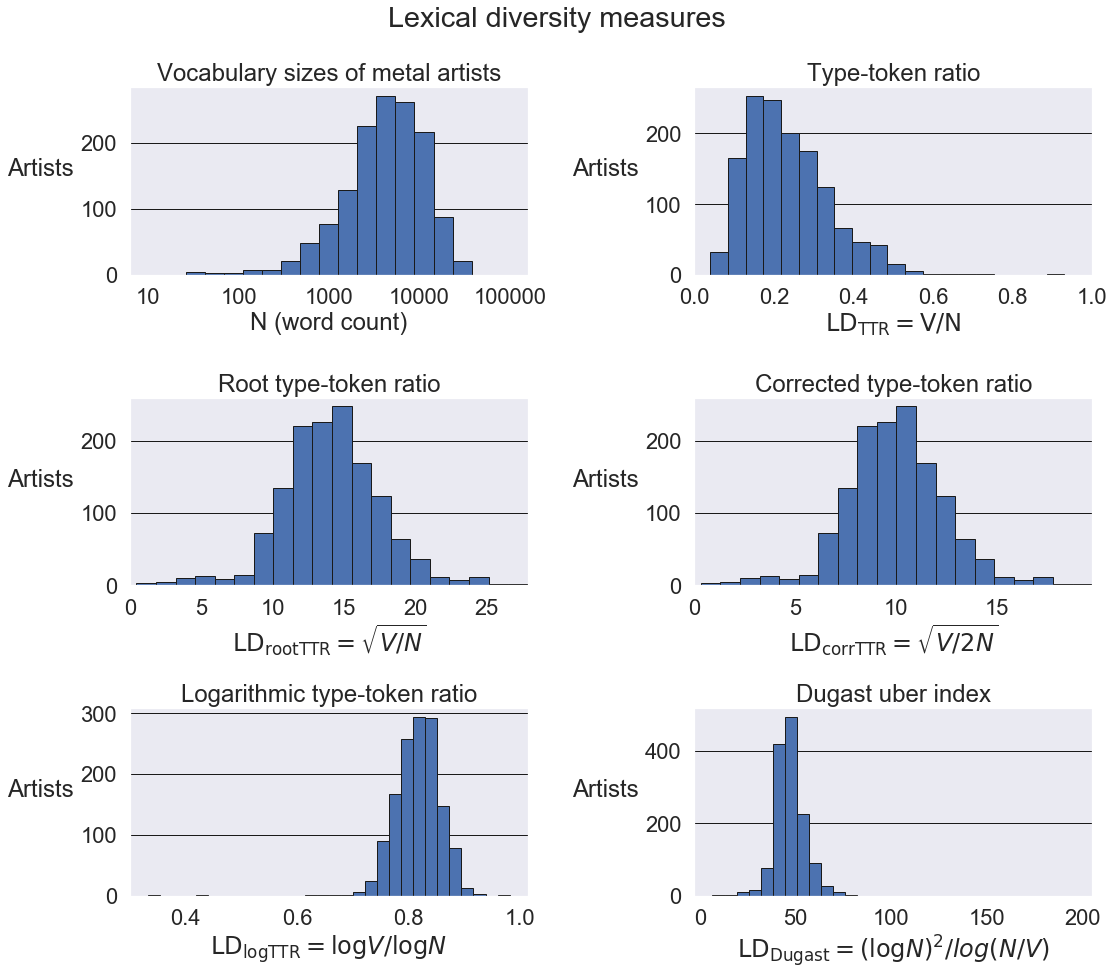

In [203]:
fig, ax = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle("Lexical diversity measures")
ax = ax.flatten()

df_bands.N.hist(bins=np.logspace(1, 5, 20), edgecolor='k', ax=ax[0])
ax[0].set_xscale('log')
ax[0].set_title("Vocabulary sizes of metal artists")
ax[0].set_xlabel("N (word count)")
ax[0].set_ylabel("Artists", rotation=0, labelpad=40)
for axis in [ax[0].xaxis, ax[0].yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax[0].grid(None)
ax[0].grid(which='major', axis='y', color='k')
ax[0].grid(which='minor', axis='y', ls=':', alpha=0.6)

df_bands.TTR.hist(bins=20, edgecolor='k', ax=ax[1])
ax[1].set_xlim(0, 1)
ax[1].set_title("Type-token ratio")
ax[1].set_xlabel("$\mathrm{LD_{TTR} = V/N}$")
ax[1].set_ylabel("Artists", rotation=0, labelpad=40)
ax[1].grid(None)
ax[1].grid(axis='y', color='k')

df_bands.rootTTR.hist(bins=20, edgecolor='k', ax=ax[2])
ax[2].set_xlim(0, df_bands.rootTTR.max())
ax[2].set_title("Root type-token ratio")
ax[2].set_xlabel("$\mathrm{LD_{rootTTR}} = \sqrt{V/N}$")
ax[2].set_ylabel("Artists", rotation=0, labelpad=40)
ax[2].grid(None)
ax[2].grid(axis='y', color='k')

df_bands.corrTTR.hist(bins=20, edgecolor='k', ax=ax[3])
ax[3].set_xlim(0, df_bands.corrTTR.max())
ax[3].set_title("Corrected type-token ratio")
ax[3].set_xlabel("$\mathrm{LD_{corrTTR}} = \sqrt{V/2N}$")
ax[3].set_ylabel("Artists", rotation=0, labelpad=40)
ax[3].grid(None)
ax[3].grid(axis='y', color='k')

df_bands.logTTR.hist(bins=30, edgecolor='k', ax=ax[4])
ax[4].set_title("Logarithmic type-token ratio")
ax[4].set_xlabel("$\mathrm{LD_{logTTR}} = \log V / \log N$")
ax[4].set_ylabel("Artists", rotation=0, labelpad=40)
ax[4].grid(None)
ax[4].grid(axis='y', color='k')

df_bands.dugast[df_bands.dugast < np.inf].hist(bins=30, edgecolor='k', ax=ax[5])
ax[5].set_title("Dugast uber index")
ax[5].set_xlabel("$\mathrm{LD_{Dugast}} = (\log N)^2 / log(N/V)$")
ax[5].set_ylabel("Artists", rotation=0, labelpad=40)
ax[5].grid(None)
ax[5].grid(axis='y', color='k')

fig.tight_layout(rect=[0, 0, 1, 0.95])

# Box plots

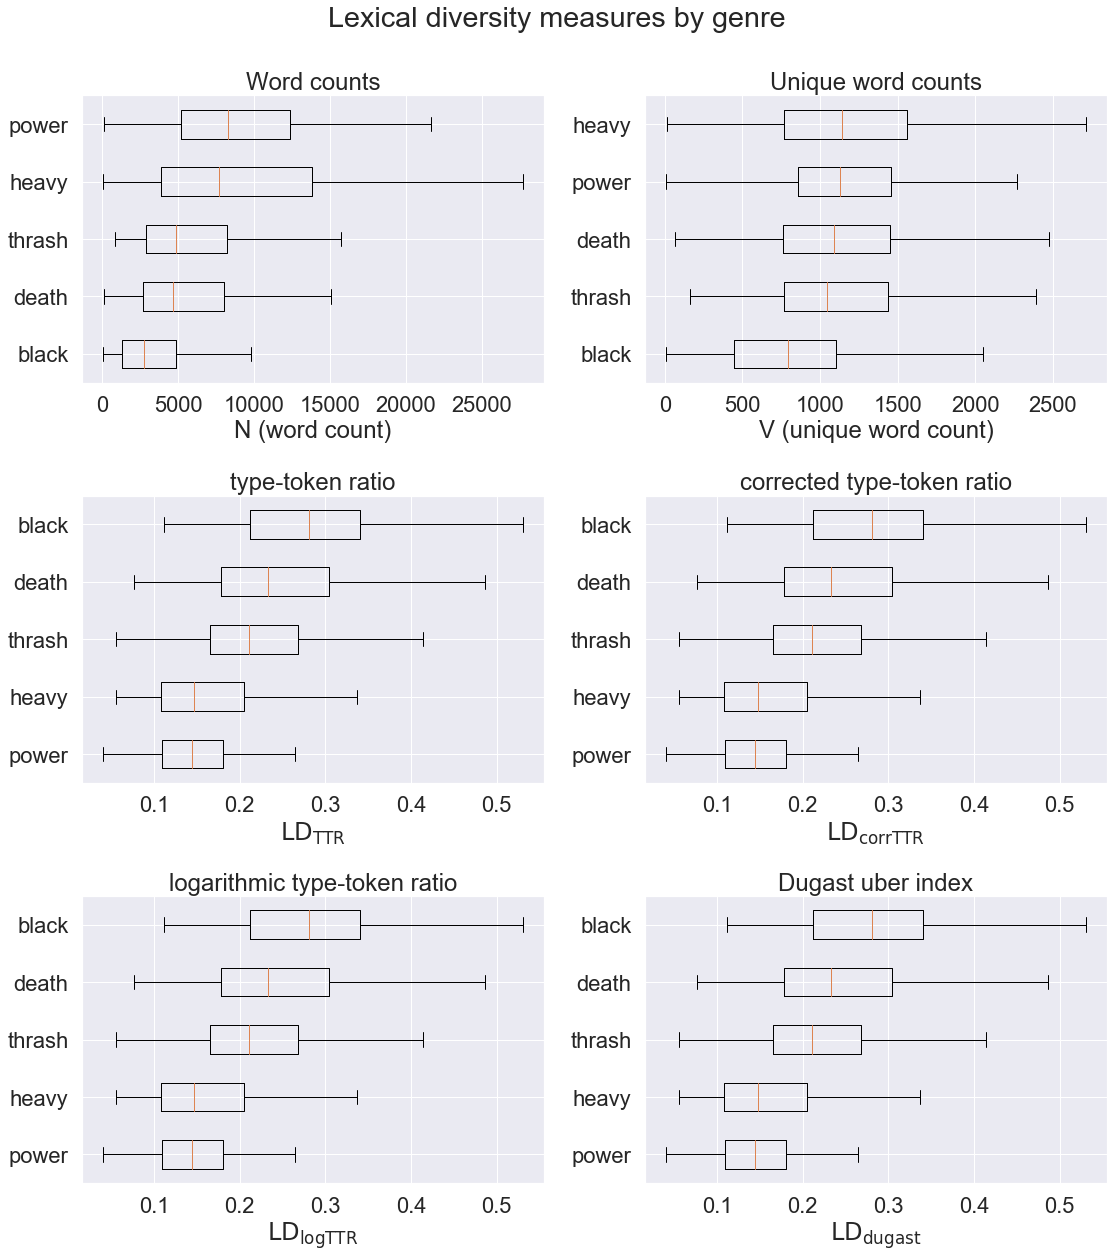

In [240]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle("Lexical diversity measures by genre")
axes = axes.flatten()

ax = axes[0]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_bands[df_bands[genre] == 1]
    boxdata.append((genre, df_genre.N))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("Word counts")
ax.set_xlabel("N (word count)")

ax = axes[1]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_bands[df_bands[genre] == 1]
    boxdata.append((genre, df_genre.V))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("Unique word counts")
ax.set_xlabel("V (unique word count)")

ax = axes[2]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_bands[df_bands[genre] == 1]
    boxdata.append((genre, df_genre.TTR))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("type-token ratio")
ax.set_xlabel(r"$\mathrm{LD_{TTR}}$")

ax = axes[3]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_bands[df_bands[genre] == 1]
    boxdata.append((genre, df_genre.TTR))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("corrected type-token ratio")
ax.set_xlabel(r"$\mathrm{LD_{corrTTR}}$")

ax = axes[4]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_bands[df_bands[genre] == 1]
    boxdata.append((genre, df_genre.TTR))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("logarithmic type-token ratio")
ax.set_xlabel(r"$\mathrm{LD_{logTTR}}$")

ax = axes[5]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_bands[df_bands[genre] == 1]
    boxdata.append((genre, df_genre.TTR))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("Dugast uber index")
ax.set_xlabel(r"$\mathrm{LD_{dugast}}$")

fig.tight_layout(rect=[0, 0, 1, 0.95])

# Scatter plots

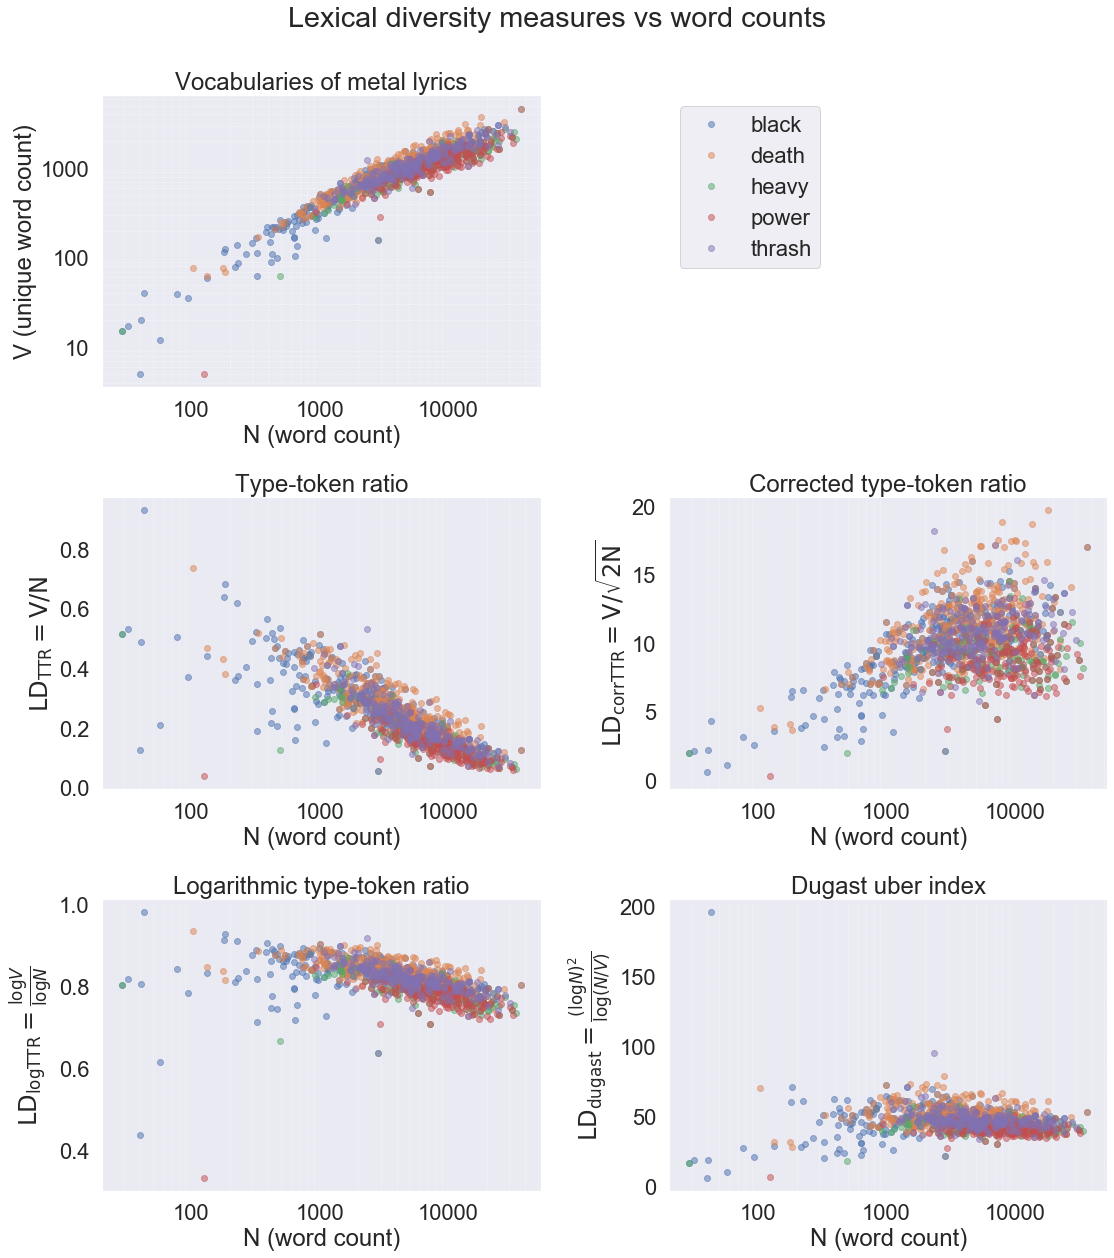

In [231]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle("Lexical diversity measures vs word counts")
axes = axes.flatten()

ax = axes[0]
for genre in genres:
    df_genre = df_bands[df_bands[genre] == 1]
    ax.plot(df_genre.N, df_genre.V, 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.set_xscale('log')
ax.set_yscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Vocabularies of metal lyrics")
ax.set_xlabel("N (word count)")
ax.set_ylabel("V (unique word count)")
ax.grid(axis='both', which='major')
ax.grid(axis='both', which='minor', ls=':', alpha=0.6)

ax = axes[1]
ax.axis('off')
for genre in genres:
    df_genre = df_bands[df_bands[genre] == 1]
    ax.plot([], [], 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.legend(frameon=True, loc='upper left')

ax = axes[2]
for genre in genres:
    df_genre = df_bands[df_bands[genre] == 1]
    ax.plot(df_genre.N, df_genre.TTR, 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Type-token ratio")
ax.set_xlabel("N (word count)")
ax.set_ylabel("$\mathrm{LD_{TTR} = V/N}$")
ax.grid(axis='both', which='major')
ax.grid(axis='both', which='minor', ls=':', alpha=0.6)

ax = axes[3]
for genre in genres:
    df_genre = df_bands[df_bands[genre] == 1]
    ax.plot(df_genre.N, df_genre.corrTTR, 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Corrected type-token ratio")
ax.set_xlabel("N (word count)")
ax.set_ylabel("$\mathrm{LD_{corrTTR} = V/\sqrt{2N}}$")
ax.grid(axis='both', which='major')
ax.grid(axis='both', which='minor', ls=':', alpha=0.6)

ax = axes[4]
for genre in genres:
    df_genre = df_bands[df_bands[genre] == 1]
    ax.plot(df_genre.N, df_genre.logTTR, 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Logarithmic type-token ratio")
ax.set_xlabel("N (word count)")
ax.set_ylabel(r"$\mathrm{LD_{logTTR}} = \frac{\log V}{\log N}$")
ax.grid(axis='both', which='major')
ax.grid(axis='both', which='minor', ls=':', alpha=0.6)

ax = axes[5]
for genre in genres:
    df_genre = df_bands[df_bands[genre] == 1]
    ax.plot(df_genre.N, df_genre.dugast, 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Dugast uber index")
ax.set_xlabel("N (word count)")
ax.set_ylabel(r"$\mathrm{LD_{dugast}} = \frac{(\log N)^2}{\log(N/V)}$")
ax.grid(axis='both', which='major')
ax.grid(axis='both', which='minor', ls=':', alpha=0.6)

fig.tight_layout(rect=[0, 0, 1, 0.95])

# Box plots with expanded genres dataset

In [252]:
df = pd.read_csv('songs-1pct.csv', low_memory=False)
genre_cols = [col for col in df.columns if 'genre_' in col]
genres = [re.sub(r"^genre\_", "", col) for col in genre_cols]

english_words = set(nltk_words.words())

def pct_english(x):
    return len(set(x).intersection(english_words)) / len(set(x))

num_english_words = df.song_darklyrics.str.split().apply(pct_english)
df = df[num_english_words > 0.5].copy()

df_bands = pd.concat(
    (
        df.groupby('band_name')[genre_cols].max(),
        df.groupby('band_name').song_darklyrics.sum()
    ),
    axis=1
)
df_bands.columns = genres + ['lyrics']

def process_lyrics(s):
    words = [word.lower().strip('.,!?') for word in s.split()]
    words = [word for word in words if word in english_words]
    return words

df_bands['words'] = df_bands.lyrics.apply(process_lyrics)

df_bands['N'] = df_bands.words.apply(len)
df_bands['V'] = df_bands.words.apply(lambda x: len(set(x)))
N = df_bands.N
V = df_bands.V
df_bands['TTR'] = V / N
df_bands['rootTTR'] = V / np.sqrt(N)
df_bands['logTTR'] = np.log(V) / np.log(N)
df_bands['corrTTR'] = V / np.sqrt(2 * N)
df_bands['dugast'] = (np.log(N))**2 / (np.log(N) - np.log(V))

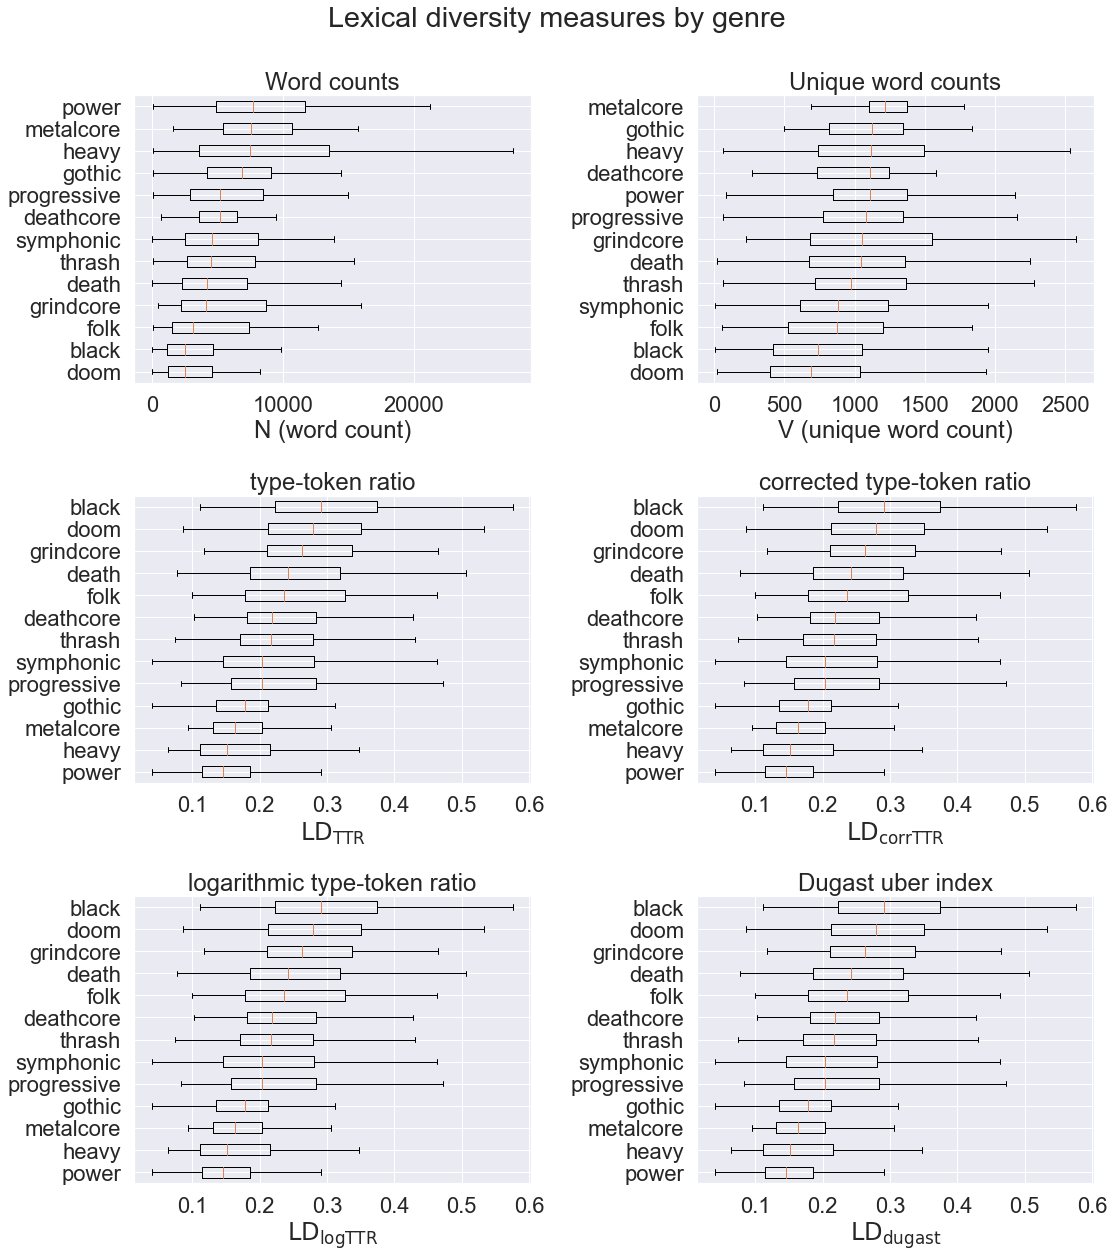

In [253]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle("Lexical diversity measures by genre")
axes = axes.flatten()

ax = axes[0]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_bands[df_bands[genre] == 1]
    boxdata.append((genre, df_genre.N))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("Word counts")
ax.set_xlabel("N (word count)")

ax = axes[1]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_bands[df_bands[genre] == 1]
    boxdata.append((genre, df_genre.V))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("Unique word counts")
ax.set_xlabel("V (unique word count)")

ax = axes[2]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_bands[df_bands[genre] == 1]
    boxdata.append((genre, df_genre.TTR))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("type-token ratio")
ax.set_xlabel(r"$\mathrm{LD_{TTR}}$")

ax = axes[3]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_bands[df_bands[genre] == 1]
    boxdata.append((genre, df_genre.TTR))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("corrected type-token ratio")
ax.set_xlabel(r"$\mathrm{LD_{corrTTR}}$")

ax = axes[4]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_bands[df_bands[genre] == 1]
    boxdata.append((genre, df_genre.TTR))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("logarithmic type-token ratio")
ax.set_xlabel(r"$\mathrm{LD_{logTTR}}$")

ax = axes[5]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_bands[df_bands[genre] == 1]
    boxdata.append((genre, df_genre.TTR))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("Dugast uber index")
ax.set_xlabel(r"$\mathrm{LD_{dugast}}$")

fig.tight_layout(rect=[0, 0, 1, 0.95])

# Box plots of individual songs instead of bands

In [254]:
df_songs = df[genre_cols + ['song_darklyrics']].copy()
df_songs.columns = genres + ['lyrics']

def process_lyrics(s):
    words = [word.lower().strip('.,!?') for word in s.split()]
    words = [word for word in words if word in english_words]
    return words

df_songs['words'] = df_songs.lyrics.apply(process_lyrics)

df_songs['N'] = df_songs.words.apply(len)
df_songs['V'] = df_songs.words.apply(lambda x: len(set(x)))
N = df_songs.N
V = df_songs.V
df_songs['TTR'] = V / N
df_songs['rootTTR'] = V / np.sqrt(N)
df_songs['logTTR'] = np.log(V) / np.log(N)
df_songs['corrTTR'] = V / np.sqrt(2 * N)
df_songs['dugast'] = (np.log(N))**2 / (np.log(N) - np.log(V))

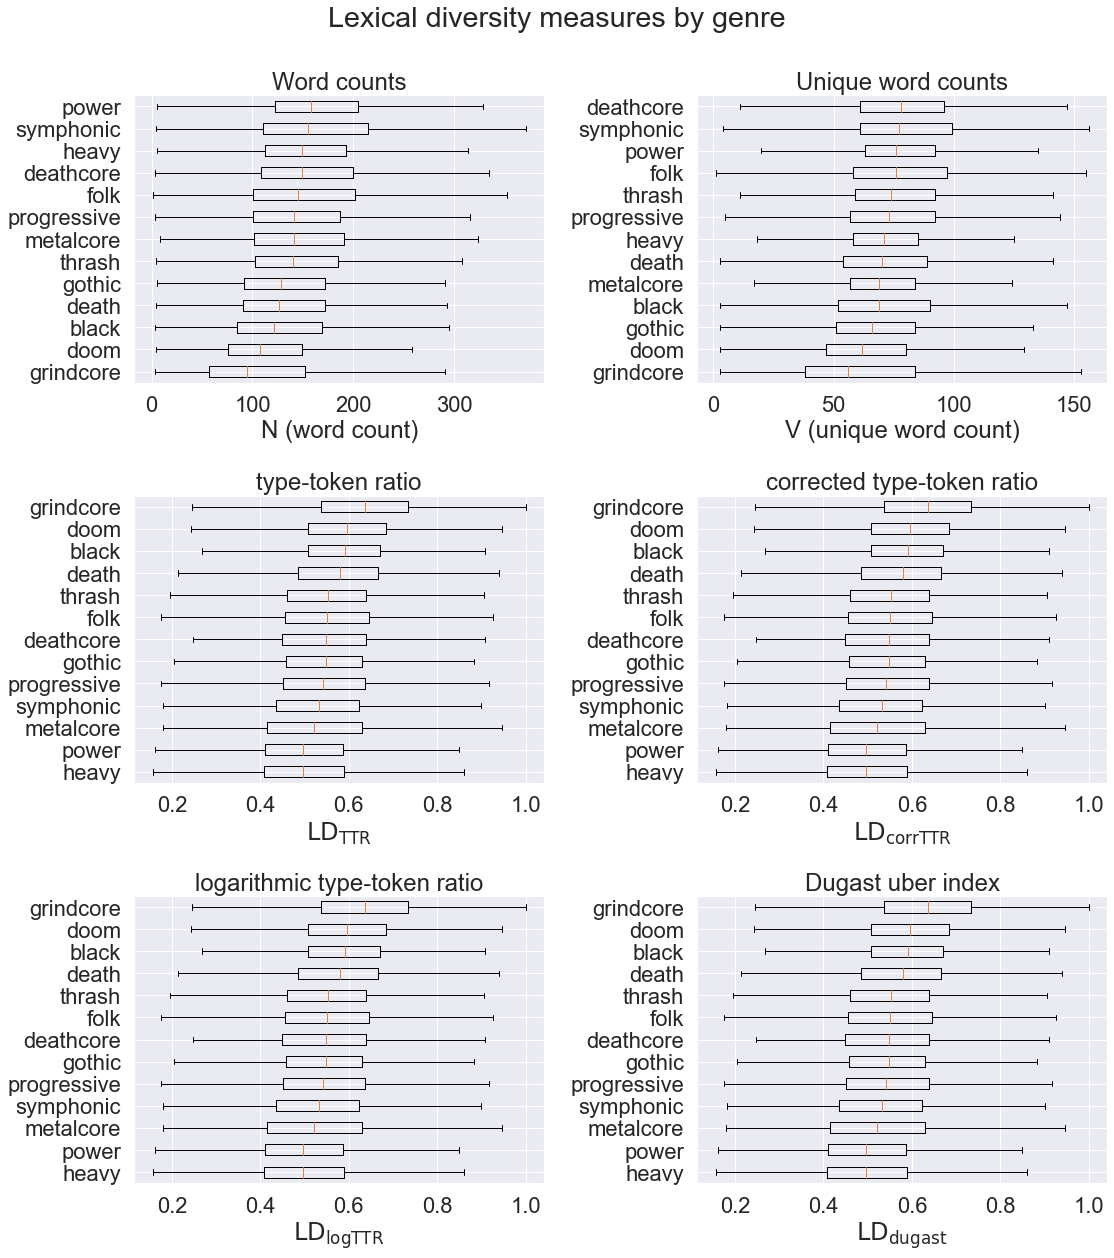

In [255]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle("Lexical diversity measures by genre")
axes = axes.flatten()

ax = axes[0]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_songs[df_songs[genre] == 1]
    boxdata.append((genre, df_genre.N))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("Word counts")
ax.set_xlabel("N (word count)")

ax = axes[1]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_songs[df_songs[genre] == 1]
    boxdata.append((genre, df_genre.V))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("Unique word counts")
ax.set_xlabel("V (unique word count)")

ax = axes[2]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_songs[df_songs[genre] == 1]
    boxdata.append((genre, df_genre.TTR))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("type-token ratio")
ax.set_xlabel(r"$\mathrm{LD_{TTR}}$")

ax = axes[3]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_songs[df_songs[genre] == 1]
    boxdata.append((genre, df_genre.TTR))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("corrected type-token ratio")
ax.set_xlabel(r"$\mathrm{LD_{corrTTR}}$")

ax = axes[4]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_songs[df_songs[genre] == 1]
    boxdata.append((genre, df_genre.TTR))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("logarithmic type-token ratio")
ax.set_xlabel(r"$\mathrm{LD_{logTTR}}$")

ax = axes[5]
boxdata = []
for i, genre in enumerate(genres):
    df_genre = df_songs[df_songs[genre] == 1]
    boxdata.append((genre, df_genre.TTR))
boxdata.sort(key=lambda x: x[1].median())
ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
ax.set_title("Dugast uber index")
ax.set_xlabel(r"$\mathrm{LD_{dugast}}$")

fig.tight_layout(rect=[0, 0, 1, 0.95])